In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, RocCurveDisplay
from imblearn.over_sampling import RandomOverSampler

Let's start importing the DataFrame from the csv file.

In [2]:
df = pd.read_csv("insurance_cross_sell.csv", index_col=0)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Then check for any NaN values.

In [3]:

df.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Fortunately we don't have NaN values in our DataFrame.
Let's check if our classes are balanced.

In [4]:
df["Gender"].value_counts()

Gender
Male      206089
Female    175020
Name: count, dtype: int64

In [5]:
df["Driving_License"].value_counts()

Driving_License
1    380297
0       812
Name: count, dtype: int64

In [6]:
df["Previously_Insured"].value_counts()

Previously_Insured
0    206481
1    174628
Name: count, dtype: int64

In [7]:
df["Vehicle_Age"].value_counts()

Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

In [8]:
df["Vehicle_Damage"].value_counts()

Vehicle_Damage
Yes    192413
No     188696
Name: count, dtype: int64

In [9]:
df["Response"].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

We note that some classes are not balanced, particularly “Response”.
We will then go on to oversample our data so that we can balance our classes.
First, however, let's code the categorical variables Gender, Vehicle_Age and Vehicle_Damage.

In [10]:
gender_mapping = {"Female": 0, "Male": 1}
age_mapping = {"< 1 Year":1, "1-2 Year":2, "> 2 Years":3}
damage_mapping = {"No": 0, "Yes": 1}
df["Gender"] = df["Gender"].map(gender_mapping)
df["Vehicle_Age"] = df["Vehicle_Age"].map(age_mapping)
df["Vehicle_Damage"] = df["Vehicle_Damage"].map(damage_mapping)

Check that coding was successful:

In [11]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1
2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0
3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1
4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


Now that the data are properly coded we can continue by going on to create training and validation sets.

In [12]:
X = df.drop("Response", axis=1).values
y = df["Response"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

We divided our DataFrame into 70% training set and 30% validation set.
Now let's apply standardization

In [13]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Now we will perform oversampling on X_train and y_train through RandomOverSampler

In [14]:
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

After doing that, we are going to train our model.
We will use the parameter “balanced” to penalize any remaining classes that are more frequent even after oversampling.

In [15]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced')

Let's now evaluate our model. We first calculate the predicted probabilities which we will need to calculate the log loss:

In [16]:
y_proba_train = lr.predict_proba(X_train_resampled)
y_proba_test = lr.predict_proba(X_test)

Calculate log loss on the training set:

In [17]:
log_loss(y_train_resampled, y_proba_train)

0.4440475983084442

And on the validation one:

In [18]:
log_loss(y_test, y_proba_test)

0.4898560197157814

In both cases we have a low log loss, a good start, our model succeeds to compute the probability of the classes well.
We then go on to make our predictions on both the training and validation set:

In [19]:
y_pred_train = lr.predict(X_train_resampled)
y_pred_test = lr.predict(X_test)

Let's continue with the confusion matrix. Let's create a function to visualize it graphically:

In [20]:
def plot_confusion_matrix(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    
    df_cm = pd.DataFrame(cm,
                        index=["Negative","Positive"],
                        columns=["Predicted Negative", "Predicted Positive"]
                        )
    sns.heatmap(df_cm, annot=True, fmt="d")

Let's visualize the training set first:

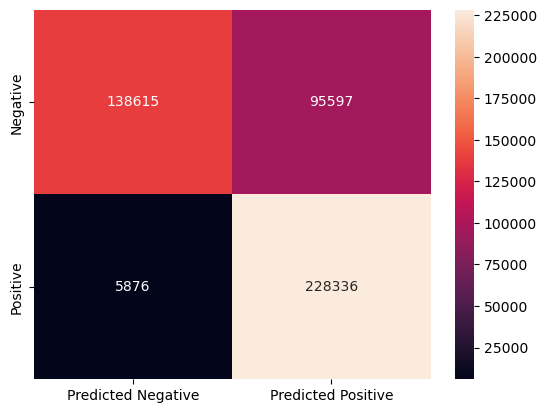

In [21]:
plot_confusion_matrix(y_train_resampled, y_pred_train)

Then the validation set:

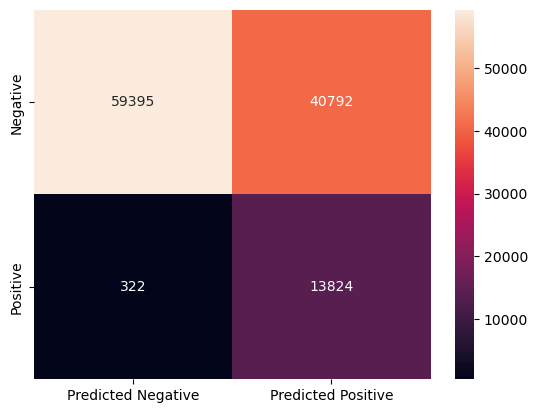

In [22]:
plot_confusion_matrix(y_test, y_pred_test)

In our case we want to minimize false negatives, that is, customers who are potentially
interested but who turn out to be uninterested.
In this view we can be very satisfied, on the train set we get 5,876 false negatives
out of 468,424 observations, or 1.25%.
Things are even better on our validation set where out of 114,333 observations we get
322 false negatives, or 0.28%.

Let's print classification report of our train set:

In [24]:
print(classification_report(y_train_resampled, y_pred_train))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73    234212
           1       0.70      0.97      0.82    234212

    accuracy                           0.78    468424
   macro avg       0.83      0.78      0.78    468424
weighted avg       0.83      0.78      0.78    468424



Classification report of validation set:

In [25]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100187
           1       0.25      0.98      0.40     14146

    accuracy                           0.64    114333
   macro avg       0.62      0.79      0.57    114333
weighted avg       0.90      0.64      0.70    114333



From the report we can see that with a precision of 0.70, a recall of 0.98 and
an accuracy of 0.78, our model is very good at classifying any customers
interested on our training set.

Things change on our validation set, in fact we see that on unseen data the model
has a somewhat low precision, 0.25 , which however is accompanied by a very high recall, 0.98.
It is therefore very likely that customers classified as potentially interested will accept
the offer. We can therefore be satisfied with the model, given also the good accuracy
of 0.64.

Finally let's go to visualize the ROC Curves and AUC of both sets:

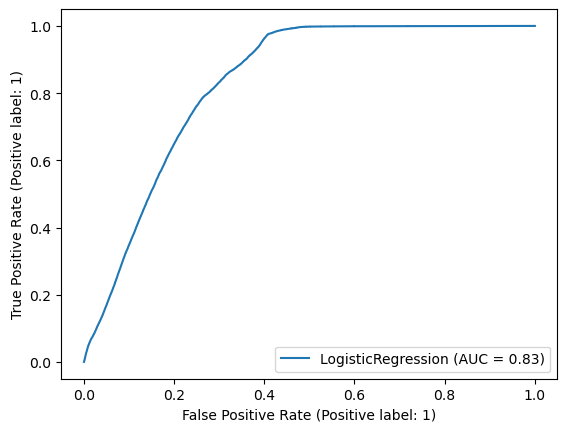

In [27]:
RocCurveDisplay.from_estimator(lr,X_train_resampled,y_train_resampled)

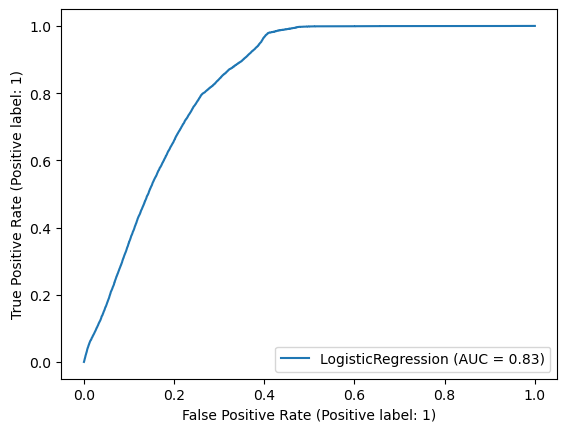

In [28]:
RocCurveDisplay.from_estimator(lr,X_test,y_test)

From the graphs we note an AUC of 0.83 on both set (training and validation), an excellent result.